# ATOC NWP: Evaluating precipitation from cumulus parameterizations

November 3, 2021
Jay.Kong@colorado.edu

# 0.0 Import all the modules

In [1]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import matplotlib.units as munits
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps

from netCDF4 import Dataset
from xarray import DataArray

from scipy.optimize import curve_fit
# from netCDF4 import Dataset
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)


print('Done importing modules now')

import warnings
warnings.filterwarnings('ignore')


Done importing modules now


# 1.0 Import one data file, assuming that we have used nco arguments to strip down files


In [4]:
directory = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_11/10_03/'
start = directory.find('ICA_11') + 7
print(start)
directory_label=directory[start:]
print(directory_label)

rainc_file = xr.open_dataset(directory+"rainc.nc")
rainnc_file = xr.open_dataset(directory+"rainnc.nc")
times = xr.open_dataset(directory+"times.nc")  # assume same for both
Times = times["Times"]


63
10_03/


(61,)


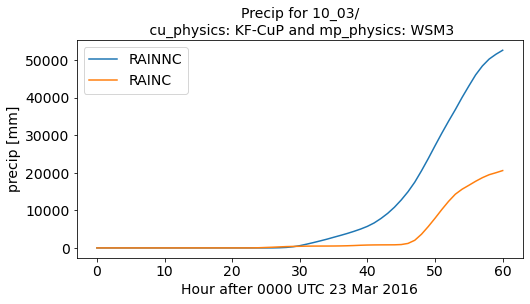

In [28]:
cum_rainnc = rainnc_file['RAINNC']
cum_rainc = rainc_file['RAINC']

#print(np.shape(cum_rain))
#print(np.shape(np.sum(cum_rain,axis=0).values)) # summing over axis=0 collapses time
#print(np.shape(np.sum(np.sum(cum_rain,axis=1),axis=1)))

time_series_rainnc = np.sum(np.sum(cum_rainnc,axis=1),axis=1)
print(np.shape(time_series_rainnc))
#print(time_series.values) # units are mm

time_series_rainc = np.sum(np.sum(cum_rainc,axis=1),axis=1)

n_times = np.shape(Times)
time_axis = np.arange(0,n_times[0])

#max_winds_2 = wspd_2.max(axis=3).max(axis=2)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
plot_label = 'test'

ax.plot(time_axis, time_series_rainnc, label="RAINNC")
ax.plot(time_axis, time_series_rainc, label="RAINC")
#ax.plot(time_axis, max_winds_at_height_2, label=label_2_subset)
#ax.plot(timearray, time_series_nested, label='10km res')

ax.legend(fontsize=14)
ax.set_xlabel("Hour after 0000 UTC 23 Mar 2016", fontsize=14)
ax.set_ylabel("precip [mm]", fontsize=14)
ax.set_title(r"Precip for "+ directory_label + '\n cu_physics: KF-CuP and mp_physics: WSM3', fontsize=14)
ax.tick_params(labelsize=14)


plt.show()

# Compare two simulations - this assumes that the domains are the same size

(61, 90, 99)
(61, 90, 99)
(61, 90, 99)
If this comparison does not use two d02 comparisons, we need to subset one of them!


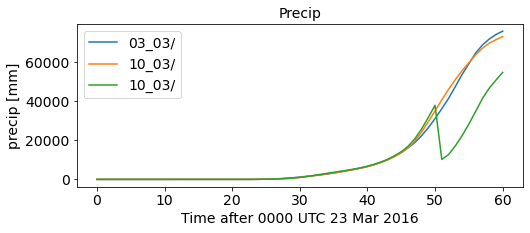

In [9]:
# Define directories
directory_1 = '/pl/active/courses/2021_fall/ATOC_NWP/students/erke2265/ICA_11/03_03/'
directory_2 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_11/10_03/'
directory_3 = '/pl/active/courses/2021_fall/ATOC_NWP/students/mcla2793/ICA_11/11_03/'

start_1 = directory_1.find('ICA_11') + 7
directory_label_1=directory_1[start_1:]
start_2 = directory_2.find('ICA_11') + 7
directory_label_2=directory_2[start_2:]
start_3 = directory_3.find('ICA_11') + 7
directory_label_3=directory_2[start_3:]


# Read in files
rainc_1 = xr.open_dataset(directory_1+"rainc.nc")
rainnc_1 = xr.open_dataset(directory_1+"rainnc.nc")
times_1 = xr.open_dataset(directory_1+"times.nc")  # assume same for both
Times_1 = times_1["Times"]

rainc_2 = xr.open_dataset(directory_2+"rainc.nc")
rainnc_2 = xr.open_dataset(directory_2+"rainnc.nc")
times_2 = xr.open_dataset(directory_2+"times.nc")  # assume same for both
Times_2 = times_2["Times"]

rainc_3 = xr.open_dataset(directory_3+"rainc.nc")
rainnc_3 = xr.open_dataset(directory_3+"rainnc.nc")
times_3 = xr.open_dataset(directory_3+"times.nc")  # assume same for both
Times_3 = times_3["Times"]

# Extract variables
cum_rainnc_1 = rainnc_1['RAINNC']
cum_rainc_1 = rainc_1['RAINC']
cum_rainnc_2 = rainnc_2['RAINNC']
cum_rainc_2 = rainc_2['RAINC']
cum_rainnc_3 = rainnc_3['RAINNC']
cum_rainc_3 = rainc_3['RAINC']

# Are these domains the same? 
print(np.shape(cum_rainc_1))
print(np.shape(cum_rainc_2))
print(np.shape(cum_rainc_3))
# test = cum_rainc_2[:,30:60,15:45]
# print(np.shape(test))

time_series_rainnc_1 = np.sum(np.sum(cum_rainnc_1,axis=1),axis=1)
time_series_rainc_1 = np.sum(np.sum(cum_rainc_1,axis=1),axis=1)
time_series_totalprecip_1 = time_series_rainnc_1 + time_series_rainc_1

cum_rainnc_2 = rainnc_2['RAINNC']
cum_rainc_2 = rainc_2['RAINC']

print("If this comparison does not use two d02 comparisons, we need to subset one of them!")
# time_series_rainnc_2 = np.sum(np.sum(cum_rainnc_2[:,30:45,15:30],axis=1),axis=1)
# time_series_rainc_2 = np.sum(np.sum(cum_rainc_2[:,30:45,15:30],axis=1),axis=1)

time_series_rainnc_2 = np.sum(np.sum(cum_rainnc_2,axis=1),axis=1)
time_series_rainc_2 = np.sum(np.sum(cum_rainc_2,axis=1),axis=1)
time_series_totalprecip_2 = time_series_rainnc_2 + time_series_rainc_2

time_series_rainnc_3 = np.sum(np.sum(cum_rainnc_3,axis=1),axis=1)
time_series_rainc_3 = np.sum(np.sum(cum_rainc_3,axis=1),axis=1)
time_series_totalprecip_3 = time_series_rainnc_3 + time_series_rainc_2

# Prepare to plot
time_axis = np.arange(0,n_times[0])

fig, ax = plt.subplots(1, 1, figsize=(8,3))
plot_label = 'test'

ax.plot(time_axis, time_series_totalprecip_1, label=directory_label_1)
ax.plot(time_axis, time_series_totalprecip_2, label=directory_label_2)
ax.plot(time_axis, time_series_totalprecip_3, label=directory_label_3)

ax.legend(fontsize=14)
ax.set_xlabel("Time after 0000 UTC 23 Mar 2016", fontsize=14)
ax.set_ylabel("precip [mm]", fontsize=14)
ax.set_title("Precip", fontsize=14)
ax.tick_params(labelsize=14)


#plt.gcf().subplots_adjust(bottom=0.3)
#plt.savefig("timeseries.pdf")

plt.show()


# If we have different size domains, we need to be clever about our summations

10_03/
(61, 90, 99)
(61, 90, 99)
If this comparison does not use two d02 comparisons, we need to subset one of them!


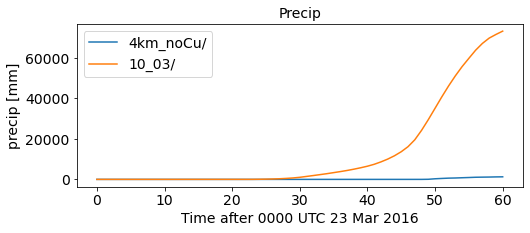

In [36]:
# # Define directories
directory_1 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jlundqui/ICA_11/4km_noCu/'
directory_2 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_11/10_03/'
start = directory.find('ICA_11') + 7
directory_label=directory[start:]
print(directory_label)

start_1 = directory_1.find('ICA_11') + 7
directory_label_1=directory_1[start_1:]
start_2 = directory_2.find('ICA_11') + 7
directory_label_2=directory_2[start_2:]

# # Figure out the x and y indices to use

# # Generate a restricted rainc.nc file
os.system("ncrcat -v RAINC "+directory_1+"wrfout_d03* rainc.nc")
os.system("ncrcat -v RAINC "+directory_1+"wrfout_d03* rainc.nc")
os.system("ncrcat -v RAINC wrfout_d03* rainc.nc")
os.system("ncrcat -v RAINC wrfout_d03* rainc.nc")


# # Read in files
rainc_1 = xr.open_dataset(directory_1+"rainc.nc")
rainnc_1 = xr.open_dataset(directory_1+"rainnc.nc")
times_1 = xr.open_dataset(directory_1+"times.nc")  # assume same for both
Times_1 = times_1["Times"]

rainc_2 = xr.open_dataset(directory_2+"rainc.nc")
rainnc_2 = xr.open_dataset(directory_2+"rainnc.nc")
times_2 = xr.open_dataset(directory_2+"times.nc")  # assume same for both
Times_2 = times_2["Times"]

# # Extract variables
cum_rainnc_1 = rainnc_1['RAINNC']
cum_rainc_1 = rainc_1['RAINC']
cum_rainnc_2 = rainnc_2['RAINNC']
cum_rainc_2 = rainc_2['RAINC']

# # Are these domains the same? 
print(np.shape(cum_rainc_1))
print(np.shape(cum_rainc_2))
# # test = cum_rainc_2[:,30:60,15:45]
# # print(np.shape(test))

time_series_rainnc_1 = np.sum(np.sum(cum_rainnc_1,axis=1),axis=1)
time_series_rainc_1 = np.sum(np.sum(cum_rainc_1,axis=1),axis=1)
time_series_totalprecip_1 = time_series_rainnc_1 + time_series_rainc_1

cum_rainnc_2 = rainnc_2['RAINNC']
cum_rainc_2 = rainc_2['RAINC']

print("If this comparison does not use two d02 comparisons, we need to subset one of them!")
# # time_series_rainnc_2 = np.sum(np.sum(cum_rainnc_2[:,30:45,15:30],axis=1),axis=1)
# # time_series_rainc_2 = np.sum(np.sum(cum_rainc_2[:,30:45,15:30],axis=1),axis=1)

time_series_rainnc_2 = np.sum(np.sum(cum_rainnc_2,axis=1),axis=1)
time_series_rainc_2 = np.sum(np.sum(cum_rainc_2,axis=1),axis=1)
time_series_totalprecip_2 = time_series_rainnc_2 + time_series_rainc_2

# # Prepare to plot
time_axis = np.arange(0,n_times[0])

fig, ax = plt.subplots(1, 1, figsize=(8,3))
plot_label = 'test'

ax.plot(time_axis, time_series_totalprecip_1, label=directory_label_1)
ax.plot(time_axis, time_series_totalprecip_2, label=directory_label_2)

ax.legend(fontsize=14)
ax.set_xlabel("Time after 0000 UTC 23 Mar 2016", fontsize=14)
ax.set_ylabel("precip [mm]", fontsize=14)
ax.set_title("Precip", fontsize=14)
ax.tick_params(labelsize=14)


# #plt.gcf().subplots_adjust(bottom=0.3)
# #plt.savefig("timeseries.pdf")

plt.show()


# 2.0 Map of the resulting precip: this example just looks at the last timestep so as to avoid reading in too many files. *** This map can be much prettier and include state contours, etc.

(90, 99)
(90, 99)
If those shapes are not the same, need to subset the larger domain
34.332943 34.332943
(1, 90, 99)
(1, 90, 99)
58.252396


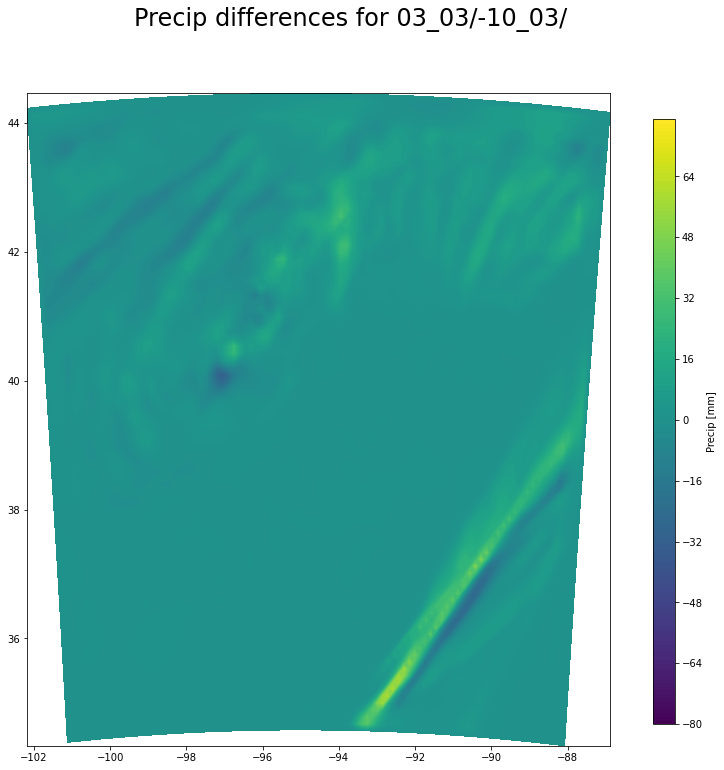

In [11]:
directory_1 = '/pl/active/courses/2021_fall/ATOC_NWP/students/erke2265/ICA_11/03_03/'
directory_2 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_11/10_03/'

start_1 = directory_1.find('ICA_11') + 7
directory_label_1=directory_1[start_1:]
start_2 = directory_2.find('ICA_11') + 7
directory_label_2=directory_2[start_2:]

wrf_filename_1 = "wrfout_d02_2016-03-24_12:00:00" # d01 for 36km, d03 for 4km
wrf_filename_2 = "wrfout_d02_2016-03-24_12:00:00"


# Create the netCDF4.Dataset object
wrf_file_1 = Dataset(directory_1+wrf_filename_1)
wrf_file_2 = Dataset(directory_2+wrf_filename_2)

# print(wrf_file_1)
# print(wrf_file_2)

# Get the perturbation pressure variable
rainc_1 = wrf_file_1.variables["RAINC"]
rainnc_1 = wrf_file_1.variables["RAINNC"]
x_lat_1 = wrf_file_1.variables["XLAT"]
x_long_1 = wrf_file_1.variables["XLONG"]

rainc_2 = wrf_file_2.variables["RAINC"]
rainnc_2 = wrf_file_2.variables["RAINNC"]
x_lat_2 = wrf_file_2.variables["XLAT"]
x_long_2 = wrf_file_2.variables["XLONG"]

print(np.shape(np.sum(rainnc_1,axis=0)))
print(np.shape(np.sum(rainnc_2,axis=0)))


print("If those shapes are not the same, need to subset the larger domain")

print(np.min(x_lat_2), np.min(x_lat_1))

rainnc_1hope = np.sum(rainnc_1,axis=0)
rainnc_2hope = np.sum(rainnc_2,axis=0)

# time_series_rainnc_2 = np.sum(np.sum(cum_rainnc_2[:,30:45,15:30],axis=1),axis=1)
# time_series_rainc_2 = np.sum(np.sum(cum_rainc_2[:,30:45,15:30],axis=1),axis=1)

test = rainnc_1hope - rainnc_2hope


print(np.shape(x_lat_1))
print(np.shape(x_long_1))
print(np.max(rainnc_1))
fig, ax = plt.subplots(1,1,figsize=(12,12), sharex=True, sharey=True)
c_levels = np.arange(-80, 80)
                       
n_times = np.shape(Times)
time_axis = np.arange(0,n_times[0])
    
im = ax.contourf(
    x_long_1[0,:,:],
    x_lat_1[0,:,:],
    test, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Precip differences for "+directory_label_1+'-'+directory_label_2, fontsize=24)

#time_label = WRF_FILES[0]
#x_axis_label = time_label[11:]

#ax.set_xlabel("Times (hours after "+x_axis_label+")")
#ax.set_ylabel("Height [m]")
#ax.set_ylim(0,500)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Precip [mm]")

plt.show()